<a href="https://colab.research.google.com/github/JonathanMartignon/DeepLearningIntroduction/blob/main/Tarea2/Tarea2_Ejercicio_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 2: Redes convolucionales
## Ejercicio 1
### Martiñón Luna Jonathan José
### Aprendizaje profundo
### Licenciatura en Ciencia de Datos

**Instrucciones:**

Diseña y entrena una red convolucional para el conjunto de datos CIFAR10. Explora diferentes diseños buscando mejorar tus resultados en el ejercicio 4 de la tarea 1. 

Discute tus resultados.

# Cambios
Básicamente se modificó la libreta para trabajar con resnet18. Se cambiaron los tamaños de 32 a 64.

---
## 1) Librerías
---

In [128]:
import torch
import torch.nn as nn
from tqdm import trange
import torch.optim as optim
try:
   from torchinfo import summary 
except:
  !pip install torchinfo
  from torchinfo import summary
import torch.nn.functional as F
import torchvision.transforms as T
from itertools import islice as take
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.models as tvm

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import random
import os

---
## 2) Funciones
---

In [80]:
def display_grid(xs, titles, clases,rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            try:
              titl = int(titles[i])
              ax[r, c].set_title(clases.get(titl,titl))
            except:
              ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()

In [81]:
def display_batch(x, titles,clases, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # Anteriormente trabajamos 1 canal (B/n)
    # Ahora son 3 (RGB)
    x = x.reshape(*x.shape[:3],3)
    # desplegamos
    display_grid(x, titles,clases, rows, cols, figsize)

In [82]:
def set_seed(seed=2209):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [83]:
#------------------------
# Para el entrenamiento
#------------------------

def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()

In [84]:
def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc

In [85]:
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

In [123]:
class RecipesDS:

    def __init__(self, root, tsfm):
        
        # guardamos la tranformación para las imágenes
        self.tsfm = tsfm
        
        # leemos el dataframe y filtramos columna healthy
        df = pd.read_csv(os.path.join(root, 'trn.csv'), index_col='item')
        df = df['healthy']
        
        # direcorios superiores
        base_dir = os.path.join(root, 'trn')
        classes = sorted(os.listdir(base_dir))
        
        # lista con las rutas a las imágenes
        self.paths = []
        # lista con las etiquetas de las imágenes
        self.labels = []
        
        # por cada clase
        for clazz in classes:
            # directorio de la clase
            class_dir = os.path.join(base_dir, clazz)
            # nombres de los archivos en el directorio de la clase
            names = sorted(os.listdir(class_dir))
            # guardamos los rutas y las etiquetas
            for name in names:
                self.paths.append(os.path.join(class_dir, name))
                self.labels.append(df.loc[clazz])

    def __getitem__(self, i):
        # obtenemos la ruta de la imagen
        path = self.paths[i]
        # cargamos la imagen
        x = Image.open(path)
        # aplicamos transformación
        x = self.tsfm(x)
        # leeamos la etiqueta
        y = np.array(self.labels[i], np.float32).reshape(1)
        # regresamos el ejemplo
        return x, y

    def __len__(self):
        # número de ejemplos en el conjunto
        return len(self.paths)

---
### 2.1) Declaraciones previas
---

In [131]:
# directorio de datos
DATA_DIR = '../datos'

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la regilla de imágenes
ROWS, COLS = 4, 8

# tamaño de la imagen
IMG_SIZE = 64

# reproducibilidad
set_seed()

Investigando un poco acerca del conjunto de datos, encuentro con que son 10 clases:
0. Airplane 
1. Automobile 
2. Bird 
3. Cat 
4. Deer 
5. Dog 
6. Frog 
7. Horse 
8. Ship 
9. Truck  

In [87]:
# Creamos un diccionario para interpretar de qué imagen se trata
# de forma más visual
clases = {0:"Avión", 1:"Automóvil", 2:"Ave", 3:"Gato",
          4:"Ciervo", 5:"Perro", 6:"Rana", 7:"Caballo",
          8:"Barco",9:"Camión"}

---
## 3) Exploración
---

In [139]:
tsfm = T.Compose([
    # redimensionamos a 64x64
    T.Resize(IMG_SIZE),
    # convertimos a ndarray
    np.array
])
# creamos un Dataset
ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=True, 
    # convertir la imagen a ndarray
    transform=tsfm, 
    # descargar el conjunto
    download=True
)

Files already downloaded and verified


images[0] shape=(64, 64, 3) dtype=uint8


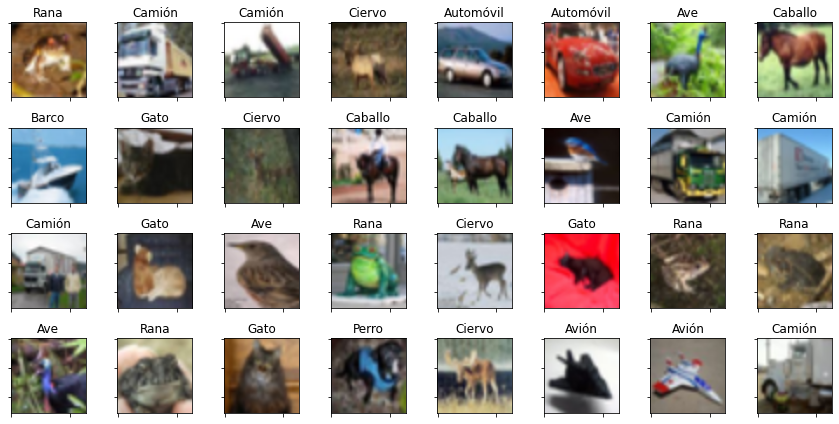

In [135]:
# cargamos algunas imágenes
images, labels = [], []
for i in range(BATCH_SIZE):
    x, y = ds[i]
    images.append(x)
    labels.append(y)

# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [str(y) for y in labels]
display_grid(images, titles,clases, ROWS, COLS)

---
### 3.1) Entrenamiento
---

x shape=torch.Size([32, 3, 64, 64]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


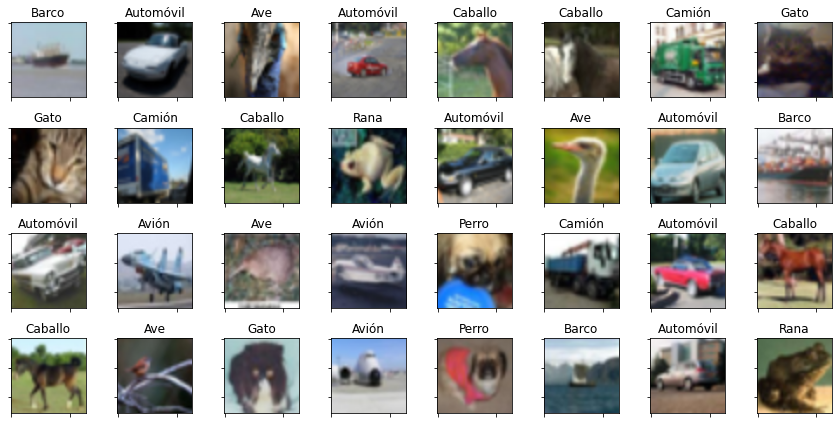

In [141]:
# transformación que convierte una imagen:
#   de numpy.ndarray    (H x W x C) en rango [0, 255]
#   a torch.FloatTensor (C x H x W) en rango [0, 1]
tsfm = T.Compose([
    # redimensionamos a 64x64
    T.Resize(IMG_SIZE),
    T.ToTensor(),
])

#---------------------------
# Conjunto de Entrenamiento del Dataset
#---------------------------

# creamos un Dataset
trn_ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=tsfm
)


#---------------------------
# Conjunto de Entrenamiento Dataloader
#---------------------------

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size = BATCH_SIZE,
    # desordenar
    shuffle=True,
)

# desplegamos un lote de imágenes
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(),clases, ROWS, COLS)

---
### 3.2) Prueba
---

x shape=torch.Size([32, 3, 64, 64]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


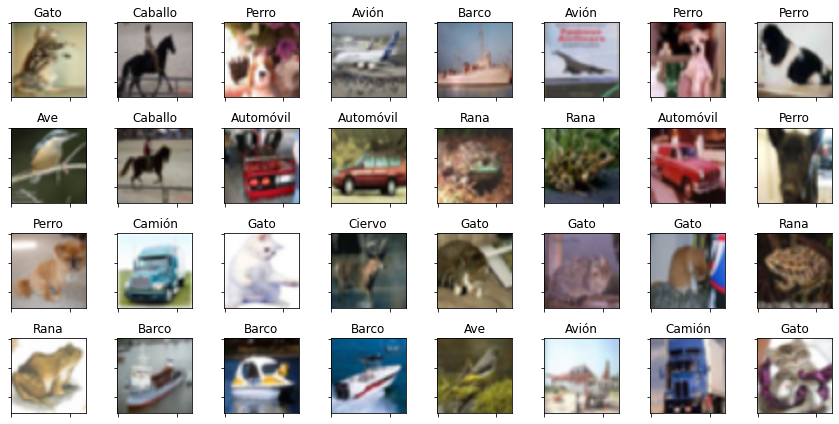

In [142]:
# creamos un Dataset
tst_ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(tst_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(),clases, ROWS, COLS)

---
## 4) Modelo
---

In [143]:
# definición del modelo
class FCN(nn.Module):
    
    # inicializador
    def __init__(self):
        
        # inicilización del objeto padre, obligatorio
        super(FCN, self).__init__()
        
        # tamaño de las capas
        # 3 canales, 32 x 32
        self.I = 3 * 64 * 64
        FC1, FC2 = 128, 10
        
        # definición de capas
        self.cls = nn.Sequential(
            
            # fc1
            # [M, 3x32x32] => [M, 128]
            nn.Linear(self.I, FC1),
            nn.Sigmoid(),
            
            # fc2
            # [M, 128] => [M, 10]
            nn.Linear(FC1, FC2)
        
        )
    
    # método para inferencia
    def forward(self, x):
        
        # aplanamos los pixeles de la imagen
        # [M, 3, 32, 32] => [M, 3x32x32]
        x = x.view(-1, self.I)
        
        # inferencia
        # [M, 3x32x32]
        x = self.cls(x)
        
        return x

---
### 4.1) Instanciación
---

In [144]:
model = FCN()
print(model)

FCN(
  (cls): Sequential(
    (0): Linear(in_features=12288, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [145]:
# inferencia con datos sintéticos
# suponiendo una imagen de 3 canales 
x = torch.zeros(1, 3, 64, 64)
y = model(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 64, 64]) => torch.Size([1, 10])


In [146]:
#Inspección de la arquitectura
summary(model, (1, 3, 64,64), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
FCN                                      --                        --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 128]                  1,572,992
│    └─Sigmoid: 2-2                      [1, 128]                  --
│    └─Linear: 2-3                       [1, 10]                   1,290
Total params: 1,574,282
Trainable params: 1,574,282
Non-trainable params: 0
Total mult-adds (M): 17.32
Input size (MB): 0.05
Forward/backward pass size (MB): 0.00
Params size (MB): 6.30
Estimated Total Size (MB): 6.35

---
## 5) Ciclo de entrenamiento
---

In [147]:
# instanciamos un modelo
model = FCN()
# entrenamos
loss_hist, acc_hist = train(model, trn_dl, tst_dl)

  5%|▌         | 1/20 [00:45<14:22, 45.38s/it]

E00 loss=[221.26,221.31] acc=[26.15,26.16]


 10%|█         | 2/20 [01:30<13:37, 45.42s/it]

E01 loss=[213.96,214.01] acc=[27.97,28.21]


 15%|█▌        | 3/20 [02:16<12:52, 45.47s/it]

E02 loss=[208.24,208.30] acc=[29.57,30.05]


 20%|██        | 4/20 [03:02<12:09, 45.57s/it]

E03 loss=[203.78,203.82] acc=[30.12,30.22]


 25%|██▌       | 5/20 [03:48<11:25, 45.68s/it]

E04 loss=[200.33,200.40] acc=[31.53,31.23]


 30%|███       | 6/20 [04:34<10:42, 45.90s/it]

E05 loss=[197.51,197.59] acc=[32.52,32.17]


 35%|███▌      | 7/20 [05:21<09:58, 46.05s/it]

E06 loss=[195.17,195.24] acc=[33.26,32.80]


 40%|████      | 8/20 [06:07<09:12, 46.03s/it]

E07 loss=[193.28,193.32] acc=[33.23,32.93]


 45%|████▌     | 9/20 [06:52<08:25, 45.93s/it]

E08 loss=[191.61,191.73] acc=[34.04,33.88]


 50%|█████     | 10/20 [07:38<07:39, 45.97s/it]

E09 loss=[190.14,190.17] acc=[34.53,34.47]


 55%|█████▌    | 11/20 [08:24<06:53, 45.99s/it]

E10 loss=[188.92,188.96] acc=[34.70,34.53]


 60%|██████    | 12/20 [09:11<06:09, 46.14s/it]

E11 loss=[187.83,187.90] acc=[35.07,34.93]


 65%|██████▌   | 13/20 [09:57<05:23, 46.15s/it]

E12 loss=[186.83,186.92] acc=[35.41,35.30]


 70%|███████   | 14/20 [10:43<04:36, 46.09s/it]

E13 loss=[185.93,186.07] acc=[35.70,35.60]


 75%|███████▌  | 15/20 [11:29<03:50, 46.05s/it]

E14 loss=[185.19,185.28] acc=[36.04,35.55]


 80%|████████  | 16/20 [12:15<03:03, 45.92s/it]

E15 loss=[184.34,184.44] acc=[36.18,35.82]


 85%|████████▌ | 17/20 [13:00<02:17, 45.94s/it]

E16 loss=[183.60,183.71] acc=[36.27,36.28]


 90%|█████████ | 18/20 [13:46<01:31, 45.88s/it]

E17 loss=[182.93,183.07] acc=[36.59,36.48]


 95%|█████████▌| 19/20 [14:32<00:45, 45.80s/it]

E18 loss=[182.23,182.29] acc=[36.77,36.73]


100%|██████████| 20/20 [15:18<00:00, 45.90s/it]

E19 loss=[181.60,181.62] acc=[36.84,36.98]


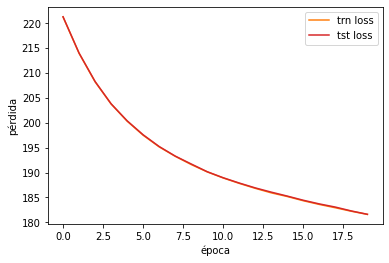

In [148]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

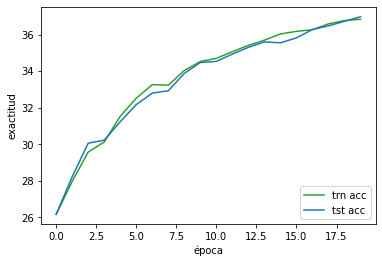

In [149]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

---
## 6) Evaluación
---

In [150]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[181.58,181.69] acc=[36.84,36.94]


---
### 6.1) Inferencia
---

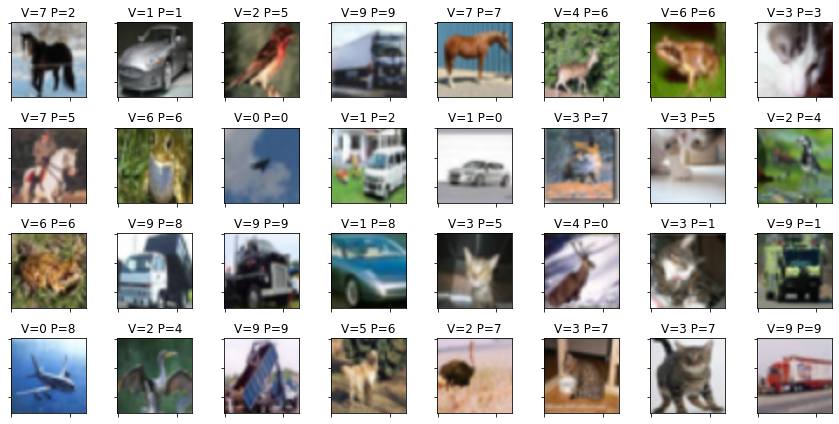

In [151]:
with torch.no_grad(): 
    x, y_true = next(iter(tst_dl))
    y_lgts = model(x)
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1)
    titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
    display_batch(x, titles,clases, ROWS, COLS)

---
## Agregados
---

Adaptaremos basándonos en el ejemplo **2C_arquitecturas**

In [152]:
resnet18 = tvm.resnet18()

In [154]:
summary(resnet18, (1, 3, 64, 64), device='cpu', verbose=0,
        col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   --                        --                        --
├─Conv2d: 1-1                            [1, 3, 64, 64]            [1, 64, 32, 32]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           [1, 64, 32, 32]           128
├─ReLU: 1-3                              [1, 64, 32, 32]           [1, 64, 32, 32]           --
├─MaxPool2d: 1-4                         [1, 64, 32, 32]           [1, 64, 16, 16]           --
├─Sequential: 1-5                        [1, 64, 16, 16]           [1, 64, 16, 16]           --
│    └─BasicBlock: 2-1                   [1, 64, 16, 16]           [1, 64, 16, 16]           --
│    │    └─Conv2d: 3-1                  [1, 64, 16, 16]           [1, 64, 16, 16]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 16, 16]           [1, 64, 16, 16]           128
│    │    └─ReLU: 3-3     

In [159]:
resnet18.fc = nn.Linear(resnet18.fc.in_features,10)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [156]:
x = torch.zeros(1, 3, 64, 64)
y = resnet18(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 64, 64]) => torch.Size([1, 1])


In [ ]:
train(resnet18, trn_dl,tst_dl, epochs=1)

  0%|          | 0/1 [00:00<?, ?it/s]